In [1]:
%load_ext pycodestyle_magic
%flake8_on

In [40]:
import os
import sys
import random as rand

import cv2
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import xml.etree.ElementTree as ET

# To be used for image and bounding boxes augmentation
import albumentations as A

# Check versions of libraries
print(f"Python: {sys.version}")
print(f"numpy: {np.__version__}")
print(f"matplotlib: {matplotlib.__version__}")
print(f"OpenCV: {cv2.__version__}")

Python: 3.8.5 (default, Jan 27 2021, 15:41:15) 
[GCC 9.3.0]
numpy: 1.19.4
matplotlib: 3.3.3
OpenCV: 4.5.2


In [41]:
CURRENT_DIR = os.getcwd()
TRAINING_SET_DIR = os.path.join(CURRENT_DIR, "images", "training_set")
VALIDATION_SET_DIR = os.path.join(CURRENT_DIR, "images", "validation_set")

IMAGE_WIDTH = 250
IMAGE_HEIGHT = 250

In [42]:
def parse_annotations(xml_file: str):
    """https://stackoverflow.com/questions/53317592/reading-pascal-voc-annotations-in-python"""
    """Parses the annotation file and returns the bounding boxes and breed names"""

    tree = ET.parse(xml_file)
    root = tree.getroot()

    all_bounding_boxes = []

    for boxes in root.iter("object"):
        filename = root.find("object").find("name").text

        ymin, xmin, ymax, xmax = None, None, None, None

        # Finds the bounding box coordinates of the dog within the image
        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)

        bounding_box = [xmin, ymin, xmax, ymax]
        all_bounding_boxes.append(bounding_box)

    return filename, all_bounding_boxes

In [43]:
def load_data(image_set_dir, image_width, image_height):
    """Loads image data and breed names from directory"""

    # Lists for image data and breed names
    image_data = []
    breed_names = []
    bounding_boxes = []

    # Iterates the files as (with the help of sorted()):
    # breedId1_dogId1
    # breedId1_dogId1.jpg
    # breedId1_dogId2
    # breedId1_dogId2.jpg
    # ...
    # breedId120_dogIdX.jpg
    for breed_folder in os.listdir(image_set_dir):
        for file in sorted(os.listdir(os.path.join(image_set_dir, breed_folder))):
            file_path = os.path.join(image_set_dir, breed_folder, file)

            # Checks images to resize and crop according to its annotated bounding box
            if file_path.endswith(".jpg"):
                image = cv2.imread(file_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # Crop the image
                image = image[bounding_boxes[-1][1]:bounding_boxes[-1][3],
                              bounding_boxes[-1][0]:bounding_boxes[-1][2]]

                resized_image = cv2.resize(image, (image_width, image_height))
                image_data.append(resized_image)

            # Checks annotation files for the breed's name and the bounding boxes
            else:
                breed_name, bounding_box = parse_annotations(file_path)
                breed_names.append(breed_name)
                bounding_boxes.append(bounding_box[0])

    return image_data, breed_names, bounding_boxes

In [44]:
image_data_train, breed_names_train, bounding_boxes_train\
    = load_data(TRAINING_SET_DIR, IMAGE_WIDTH, IMAGE_HEIGHT)
image_data_validation, breed_names_validation, bounding_boxes_validation\
    = load_data(VALIDATION_SET_DIR, IMAGE_WIDTH, IMAGE_HEIGHT)

In [45]:
def image_view(images, labels):
    """Displays a 3x3 subplot of randomly selected images"""

    fig, ax = plt.subplots(3, 3, figsize=(12, 12))

    for i in range(3):
        for j in range(3):
            # Selects a random image and displays it
            index = rand.randint(0, len(images) - 1)
            ax[i, j].imshow(images[index])

            # Displays the breed's name as the title
            ax[i, j].set_title(f"Breed: {labels[index]}")

    plt.show()

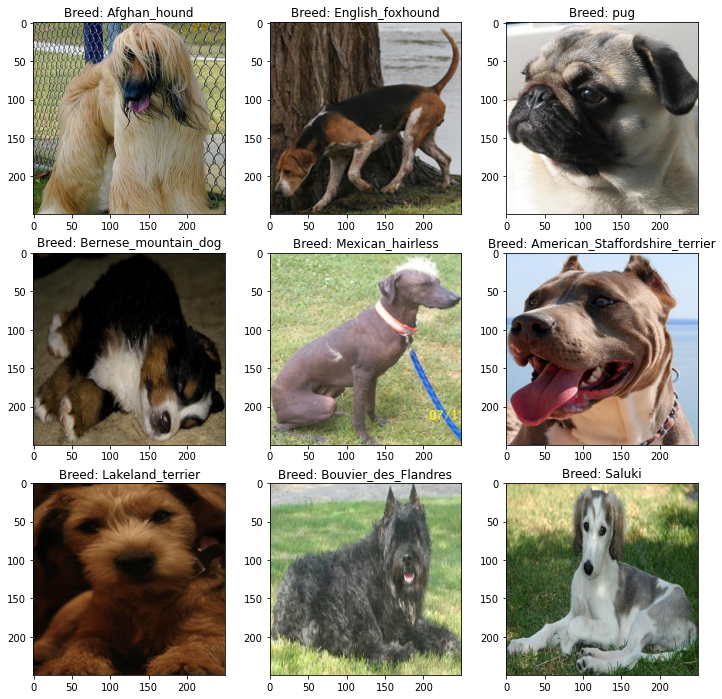

In [46]:
image_view(image_data_train, breed_names_train)